In [1]:
# from transformers import AutoTokenizer, TFAutoModel
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

E0000 00:00:1757838756.847847      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver('local')
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    print('die')
    strategy = tf.distribute.get_strategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1757838777.261858      10 service.cc:148] XLA service 0x56ba6c851300 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757838777.261906      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1757838777.261910      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1757838777.261913      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1757838777.261916      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1757838777.261919      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1757838777.261922      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1757838777.261924      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1757838777.261927      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [4]:
df = pd.read_csv('/kaggle/input/flickr30k/captions.txt')

In [5]:
df['image_name']

0         1000092795.jpg
1         1000092795.jpg
2         1000092795.jpg
3         1000092795.jpg
4         1000092795.jpg
               ...      
158910     998845445.jpg
158911     998845445.jpg
158912     998845445.jpg
158913     998845445.jpg
158914     998845445.jpg
Name: image_name, Length: 158915, dtype: object

In [6]:
'''df['image_name'] = df['image_name'].apply(lambda x: x.split('#')[0])'''
df = df.drop_duplicates(subset='image_name', keep='first')[:256*64]

In [7]:
paths = df['image_name'].values
'''captions = df['caption'].values'''

"captions = df['caption'].values"

In [8]:
images = []
HEIGHT,WIDTH = 128,128
for i in paths:
    img = Image.open('/kaggle/input/flickr30k/flickr30k_images/'+i).convert("RGB")
    img = img.resize((HEIGHT,WIDTH))
    img = np.asarray(img)/255.0
    images.append(img)


images = np.array(images)  # Make sure images is a NumPy array

print("Images shape:", images.shape)
print("Images dtype:", images.dtype)
print("Images min:", images.min())  # Use numpy's min method
print("Images max:", images.max())  # Use numpy's max method
print("Images mean:", images.mean())

Images shape: (16384, 128, 128, 3)
Images dtype: float64
Images min: 0.0
Images max: 1.0
Images mean: 0.4174092668187803


In [9]:
vqvae_train = tf.data.Dataset.from_tensor_slices(images)
vqvae_train = vqvae_train.map(lambda x: tf.cast(x, tf.float32), num_parallel_calls=tf.data.AUTOTUNE)
'''vqvae_train = vqvae_train.shuffle(1000,seed=seed)'''
vqvae_train = vqvae_train.batch(256, drop_remainder=True)  # Drop the last incomplete batch
vqvae_train = vqvae_train.prefetch(tf.data.AUTOTUNE).cache()

vqvae_train = strategy.experimental_distribute_dataset(vqvae_train)

In [10]:
import tensorflow as tf
from IPython.display import clear_output
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Hyperparameters
embedding_dim = 256
num_embeddings = 256
input_shape = (HEIGHT, WIDTH, 3)


roshnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(224,224,3))
roshnet.trainable = False
name = 'conv3_block4_out'
outputs = roshnet.get_layer(name).output
roshnet_model = tf.keras.Model(inputs=roshnet.input, outputs=outputs)

@tf.function
def codebook_kl_loss(encodings, num_embeddings, eps=1e-10):
    # Flatten the encoding indices
    encodings = tf.reshape(encodings, [-1])

    # One-hot encode the indices
    one_hot = tf.one_hot(encodings, depth=num_embeddings)

    # Histogram
    usage = tf.reduce_sum(one_hot, axis=0)

    # Normalize
    usage = usage / (tf.reduce_sum(usage) + eps)

    # KL divergence to uniform prior (1 / num_embeddings)
    kl = tf.reduce_sum(usage * tf.math.log((usage + eps) * num_embeddings))
    return kl
def orthogonal_loss(codebook):
    E = tf.nn.l2_normalize(codebook,axis=1)
    sim_matrix = tf.matmul(E, E, transpose_b=True)
    off_diag = sim_matrix - tf.linalg.diag(tf.linalg.diag_part(sim_matrix))
    return tf.reduce_sum(tf.square(off_diag))
    
def codebook_entropy_loss(indices, num_embeddings):
    counts = tf.math.bincount(indices, minlength=num_embeddings, maxlength=num_embeddings, dtype=tf.float32)
    probs = counts / (tf.reduce_sum(counts) + 1e-8)

    entropy = -tf.reduce_sum(probs * tf.math.log(probs + 1e-8))
    return -entropy 

class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim,  **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        #self.last_used_indices = None
        # Create the embeddings (the codebook)
        self.latent_basis = self.add_weight(
            shape=(self.num_embeddings, self.embedding_dim),
            initializer=tf.random_uniform_initializer(),
            trainable=True,
            name="embeddings",
        )
        self.dense_proj = tf.keras.layers.Dense(self.embedding_dim)

    def call(self, inputs):
        embeddings = self.dense_proj(self.latent_basis)
        input_shape = tf.shape(inputs)
        flat_inputs = tf.reshape(inputs, [-1, self.embedding_dim])
        flat_inputs = tf.cast(flat_inputs, dtype=embeddings.dtype)
        noise = tf.random.normal(shape=tf.shape(flat_inputs), mean=0.0, stddev=0.15)
        flat_inputs += noise
    
        # Compute distances to embedding vectors
        '''distances = (
            tf.reduce_sum(flat_inputs ** 2, axis=1, keepdims=True)
            - 2 * tf.matmul(flat_inputs, self.embeddings, transpose_b=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=1)
        )'''
        flat_inputs_norm = tf.nn.l2_normalize(flat_inputs, axis=1)  # [N, D]
        embeddings_norm = tf.nn.l2_normalize(embeddings, axis=1)  # [K, D]
        
        # Cosine similarity = dot product of normalized vectors
        cosine_sim = tf.matmul(flat_inputs_norm, embeddings_norm, transpose_b=True)  # [N, K]
        
        # Convert similarity to distance (cosine distance = 1 - cosine similarity)
        distances = 1.0 - cosine_sim
        # Find nearest embedding index
        encoding_indices = tf.argmin(distances, axis=1)
    
        # Get quantized vectors
        quantized = tf.gather(embeddings, encoding_indices)
        quantized = tf.reshape(quantized, input_shape)
    
        # Compute losses
        e_latent_loss = tf.reduce_mean((tf.stop_gradient(quantized) - inputs) ** 2)
        q_latent_loss = tf.reduce_mean((quantized - tf.stop_gradient(inputs)) ** 2)

        # ortho_loss = orthogonal_loss(embeddings)
    
        # entropy_loss = codebook_entropy_loss(encoding_indices, num_embeddings = self.num_embeddings)
        
        kldiv_loss = codebook_kl_loss(encoding_indices, num_embeddings=self.num_embeddings)
   
        # Total loss
        loss = q_latent_loss + 0.25 * e_latent_loss + 0.3 * kldiv_loss# + 0.005 * ortho_loss
        self.add_loss(loss) 
    
        # Straight-through estimator
        quantized = inputs + tf.stop_gradient(quantized - inputs)
    
        return quantized  # Optionally, also return encoding_indices

    def get_codebook(self):
        codebook = self.dense_proj(self.latent_basis)
        return codebook

def residual_block(x, filters):
    skip = x
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.add([x, skip])
    x = layers.ReLU()(x)
    return x

# Encoder
from tensorflow.keras.layers import Layer, Conv2D, Add
import tensorflow as tf

import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Add
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable(package="Custom")
class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        self.filters = input_shape[-1]
        self.f = Conv2D(self.filters // 8, kernel_size=1, padding='same')
        self.g = Conv2D(self.filters // 8, kernel_size=1, padding='same')
        self.h = Conv2D(self.filters, kernel_size=1, padding='same')
        super().build(input_shape)

    def call(self, x):
        f = self.f(x)  # (B, H, W, C//8)
        g = self.g(x)
        h = self.h(x)  # (B, H, W, C)

        shape_f = tf.shape(f)
        B, H, W = shape_f[0], shape_f[1], shape_f[2]

        f_flat = tf.reshape(f, [B, H * W, self.filters // 8])
        g_flat = tf.reshape(g, [B, H * W, self.filters // 8])
        h_flat = tf.reshape(h, [B, H * W, self.filters])

        beta = tf.nn.softmax(tf.matmul(f_flat, g_flat, transpose_b=True), axis=-1)  # (B, N, N)

        o = tf.matmul(beta, h_flat)  # (B, N, C)
        o = tf.reshape(o, [B, H, W, self.filters])

        return Add()([x, o])  # Residual connection

    def get_config(self):
        config = super().get_config()
        return config


def get_encoder():
    inputs = keras.Input(shape=input_shape)

    # Downsample 1: 128x128 → 64x64
    x = layers.Conv2D(256, 4, strides=2, padding='same', activation='relu')(inputs)
    for _ in range(2): x = residual_block(x, 256)

    # Downsample 2: 64x64 → 32x32
    x = layers.Conv2D(512, 4, strides=2, padding='same', activation='relu')(x)
    for _ in range(2): x = residual_block(x, 512)

    # Downsample 3: 32x32 → 16x16
    x = layers.Conv2D(512, 4, strides=2, padding='same', activation='relu')(x)
    for _ in range(3): x = residual_block(x, 512)
    
    x = SelfAttention()(x)
    
    x = layers.Conv2D(embedding_dim, 1, padding='same')(x)
    # x = layers.LayerNormalization()(x) 
    # Final latent
    return keras.Model(inputs, x, name="encoder")


# Decoder
def get_decoder():
    inputs = keras.Input(shape=(16, 16, embedding_dim))  # Start from encoded shape

    x = layers.UpSampling2D(size=(2, 2))(inputs)
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    for _ in range(3): x = residual_block(x, 512)

    x = SelfAttention()(x)
    
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    for _ in range(2): x = residual_block(x, 512)

    x = layers.UpSampling2D(size=(2, 2))(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    for _ in range(2): x = residual_block(x, 256)

    x = layers.Conv2D(3, 1, padding='same', activation='sigmoid')(x)

    return keras.Model(inputs, x, name="decoder")

def jom_loss(y_true, y_pred):
    # Perceptual loss (L1 on VGG features)
    y_true_resized = tf.image.resize(y_true, (224, 224))*255
    y_pred_resized = tf.image.resize(y_pred, (224, 224))*255

    y_true_roshnet = tf.keras.applications.resnet50.preprocess_input(y_true_resized)
    y_pred_roshnet = tf.keras.applications.resnet50.preprocess_input(y_pred_resized)
    roshnet_true = tf.stop_gradient(roshnet_model(y_true_roshnet))
    roshnet_pred = roshnet_model(y_pred_roshnet)
    
    perceptual_loss = tf.reduce_mean(tf.square(roshnet_true - roshnet_pred))
    return perceptual_loss
    
with strategy.scope():
    encoder = get_encoder()
    decoder = get_decoder()
    inputs = keras.Input(shape=input_shape)
    z = encoder(inputs)
    quantized = VectorQuantizer(num_embeddings, embedding_dim,name='quantizer')(z)
    reconstructions = decoder(quantized)
    
    # This model has more neurons than my brain
    vqvae = keras.Model(inputs, reconstructions, name="vqvae")
    
    vqvae_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

sample_batch = np.array(images[:5])  # Get 10 sample images for monitoring

# Compile and train
vqvae.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1757838986.165011      10 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "vqvae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 16, 16, 256)    │    32,747,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ quantizer (VectorQuantizer)     │ (None, 16, 16, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 128, 128, 3)    │    31,031,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,910,915 (243.80 MB)

 Trainable params: 63,886,339 (243.71 MB)

 Non-trainable params: 24,576 (96.00 KB)

In [11]:
def get_discriminator(input_shape=(128, 128, 3)):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)  # 128→64
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)       # 64→32
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)       # 32→16
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, 4, strides=2, padding='same')(x)       # 16→8
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, 4, padding='valid')(x)  # output single scalar or patch (5x5 or so)
    
    # Flatten and output
    x = layers.Flatten()(x)
    outputs = layers.Activation('sigmoid')(x)  # probability real/fake

    return keras.Model(inputs, outputs, name="discriminator")
    
with strategy.scope():
    discriminator = get_discriminator()
    
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 64, 64, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 16, 16, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 8, 8, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 5, 5, 1)        │         8,193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 25)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,768,321 (10.56 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [12]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
def discriminator_loss(real,fake):
    real_loss = loss(tf.ones_like(real)*0.9,real)
    fake_loss = loss(tf.zeros_like(fake),fake)
    total_loss = real_loss+fake_loss
    return total_loss

def generator_loss(fake):
    gen_loss = loss(tf.ones_like(fake),fake)
    return gen_loss

In [13]:
from tensorflow.keras import backend as K

def laplacian_filter():
    # 3x3 Laplacian kernel
    kernel = tf.constant([[0.,  1., 0.],
                          [1., -4., 1.],
                          [0.,  1., 0.]], dtype=tf.float32)
    kernel = tf.reshape(kernel, [3, 3, 1, 1])
    kernel = tf.repeat(kernel, repeats=3, axis=2)  # Apply to each RGB channel
    return kernel

def apply_laplacian(img):
    kernel = laplacian_filter()
    return tf.nn.conv2d(img, kernel, strides=1, padding='SAME')

def high_freq_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    lap_true = apply_laplacian(y_true)
    lap_pred = apply_laplacian(y_pred)
    
    return tf.reduce_mean(tf.abs(lap_true - lap_pred))

In [14]:
@tf.function
def train_step(images,epoch):
    with tf.GradientTape() as vq_tape, tf.GradientTape() as disc_tape:
        vqvae_output = vqvae(images,training=True)
        disc_true = discriminator(images,training=True)
        disc_false = discriminator(vqvae_output,training=True)
        
        disc_loss = discriminator_loss(disc_true,disc_false)
        gen_loss = generator_loss(disc_false)

        perceptual_loss = jom_loss(images,vqvae_output)
        quantizer_loss = tf.reduce_mean(vqvae.losses)
        pixel_wise_loss = tf.reduce_mean(tf.abs(images-vqvae_output))
        hfl = high_freq_loss(images,vqvae_output)
        
        gen_weight = tf.minimum(0.4, tf.cast(epoch//5, tf.float32) * 0.05)
        perceptual_weight = tf.minimum(0.5, tf.cast(epoch//5, tf.float32) * 0.01)      
        total_gen_loss = pixel_wise_loss + quantizer_loss + gen_weight * gen_loss + perceptual_weight * perceptual_loss + 0.1 * hfl
        
        gradients_of_vqvae = vq_tape.gradient(total_gen_loss, vqvae.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        vqvae_optimizer.apply_gradients(zip(gradients_of_vqvae, vqvae.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        output_min = tf.reduce_min(vqvae_output)
        output_max = tf.reduce_max(vqvae_output)
        output_mean = tf.reduce_mean(vqvae_output)
        return (
            gen_loss, pixel_wise_loss, perceptual_loss, quantizer_loss, disc_loss,
            tf.reduce_min(vqvae_output),
            tf.reduce_max(vqvae_output),
            tf.reduce_mean(vqvae_output),
            total_gen_loss,
            hfl
            )

In [15]:
@tf.function
def distributed_train_step(batch, epoch):
    return strategy.run(train_step, args=(batch, epoch))

In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt

def plot_codebook_similarity(codebook, title="Codebook Cosine Similarity"):
    """
    codebook: Tensor of shape [num_codes, dim]
    """
    codebook = tf.convert_to_tensor(codebook)

    # Normalize for cosine similarity
    norm_e = tf.nn.l2_normalize(codebook, axis=-1)
    sim_matrix = tf.matmul(norm_e, norm_e, transpose_b=True)

    # Plot heatmap
    plt.figure(figsize=(6, 6))
    plt.imshow(sim_matrix.numpy(), cmap="viridis", interpolation="nearest")
    plt.colorbar(label="Cosine Similarity")
    plt.title(title)
    plt.xlabel("Code Index")
    plt.ylabel("Code Index")
    plt.show()

In [17]:
def plot_similarity_histogram(codebook):
    norm_e = tf.nn.l2_normalize(codebook, axis=-1)
    sim_matrix = tf.matmul(norm_e, norm_e, transpose_b=True)

    # remove diagonal self-similarities
    mask = ~tf.eye(sim_matrix.shape[0], dtype=tf.bool)
    sims = tf.boolean_mask(sim_matrix, mask)

    plt.hist(sims.numpy(), bins=50, density=True, alpha=0.7)
    plt.title("Distribution of Codebook Cosine Similarities")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Density")
    plt.show()


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from IPython.display import clear_output
from tqdm import tqdm

def run_custom_callback(data_sample, epoch, every_n_epochs, num_images=5):
    current_epoch = epoch + 1
    save_model = (current_epoch % 6 == 0)
    show_plot = (current_epoch % every_n_epochs == 0)

    if not show_plot:
        return

    clear_output(wait=True)

    encoder = vqvae.get_layer(name='encoder')
    vq_layer = vqvae.get_layer(name='quantizer')
    codebook = vq_layer.get_codebook()
    decoder = vqvae.get_layer(name='decoder')

    if save_model:
        models[epoch+1] = [encoder,decoder,codebook] 

    z = encoder(data_sample)  # shape: (B, H, W, embedding_dim)
    z_flat = tf.reshape(z, [-1, z.shape[-1]])  # Flatten to (B*H*W, embedding_dim)
    mean = tf.reduce_mean(z_flat, axis=0)       # Shape: (D,)
    stddev = tf.math.reduce_std(z_flat, axis=0)  # Shape: (D,)

    distances = (
        tf.reduce_sum(z_flat ** 2, axis=1, keepdims=True)
        - 2 * tf.matmul(z_flat, codebook, transpose_b=True)
        + tf.reduce_sum(codebook ** 2, axis=1)
    )

    encoding_indices = tf.argmin(distances, axis=1)
    print("Unique encoding indices used:", len(np.unique(encoding_indices.numpy())))

    reconstructions = vqvae(data_sample, training=False).numpy()
    reconstructions = np.clip(reconstructions, 0., 1.)

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
    for i in range(num_images):
        axes[0, i].imshow(data_sample[i])
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructions[i])
        axes[1, i].axis('off')

    plt.suptitle(f"Epoch {current_epoch} — Input vs Reconstruction | Codebook Usage: {len(np.unique(encoding_indices.numpy()))}/256")
    
    plt.tight_layout()

    # Save the plot only if model is also saved (i.e., every 6 epochs)
    if save_model:
        plot_filename = f'{current_epoch}_Epoch_Reconstructions.png'
        plt.savefig(plot_filename)
        print(f"Reconstruction plot saved as {plot_filename}")

    plt.show()
    plot_codebook_similarity(codebook)
    plot_similarity_histogram(codebook)

In [19]:
test = []
for i in os.listdir('/kaggle/input/flickr8k/Images')[10:15]:
    img = Image.open('/kaggle/input/flickr8k/Images/' + i)
    img = img.resize((128,128))
    img = np.asarray(img)/255.0
    test.append(img)

In [20]:
EPOCHS = 99 # int(input('ENTER THEM DIGITS : '))

models={}
def train_model(train_dataset, epochs, data_sample, every_n_epochs=3):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        total_gen_loss = 0
        total_pixel_loss = 0
        total_quant_loss = 0
        total_disc_loss = 0
        total_percep_loss = 0
        total_total_gen_loss = 0
        total_hfl_loss = 0
        steps = 0

        for batch in tqdm(train_dataset, desc="Training", leave=False):
            per_replica_output = distributed_train_step(batch, epoch+1)
        
            gen_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_output[0], axis=None)
            pixel_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_output[1], axis=None)
            perceptual_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_output[2], axis=None)
            quantizer_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_output[3], axis=None)
            disc_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_output[4], axis=None)
            
            out_min = strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_output[5], axis=None)
            out_max = strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_output[6], axis=None)
            out_mean = strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_output[7], axis=None)# Accumulate
            step_total_gen_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_output[8], axis=None)# Accumulate
            hfl_loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_output[9], axis=None)# Accumulate

            total_gen_loss += gen_loss.numpy()
            total_pixel_loss += pixel_loss.numpy()
            total_quant_loss += quantizer_loss.numpy()
            total_disc_loss += disc_loss.numpy()
            total_percep_loss += perceptual_loss.numpy()
            total_total_gen_loss += step_total_gen_loss.numpy()
            total_hfl_loss += hfl_loss.numpy()
            steps += 1


        print(f"Epoch {epoch + 1} Summary:")
        print(f"  Generator Loss: {total_gen_loss / steps:.4f}")
        print(f"  Pixel-wise Loss: {total_pixel_loss / steps:.4f}")
        print(f"  Perceptual Loss: {total_percep_loss / steps:.4f}")
        print(f"  Quantizer Loss: {total_quant_loss / steps:.4f}")
        print(f"  Discriminator Loss: {total_disc_loss / steps:.4f}")
        print(f"  Total HFL Loss: {total_hfl_loss / steps:.4f}")
        print(f"Output Stats — min: {out_min.numpy()}, max: {out_max.numpy()}, mean: {out_mean.numpy()}")
        print(f"  Total Gen Loss: {total_total_gen_loss / steps:.4f}")

        # Run callback
        
        run_custom_callback(data_sample, epoch, every_n_epochs)
        
is_training = int(input('1 for yes \n 0 for no \n Do you Want to Train ? '))

if is_training:
    train_model(vqvae_train, EPOCHS,np.array(test))

else:
    
    '''model = tf.keras.models.load_model('/kaggle/input/vqganbest_one/tensorflow2/default/1/84_epoch_model.keras', custom_objects={
            'codebook_kl_loss': codebook_kl_loss,
            'VectorQuantizer': VectorQuantizer,
            'SelfAttention': SelfAttention})'''
    with strategy.scope():
        encoder = tf.keras.models.load_model('/kaggle/input/vqgan-parts/vqgan_epoch_78/epoch_78_encoder.keras',custom_objects={'SelfAttention': SelfAttention})
        decoder = tf.keras.models.load_model('/kaggle/input/vqgan-parts/vqgan_epoch_78/epoch_78_decoder.keras',custom_objects={'SelfAttention': SelfAttention})
        codebook = np.load('/kaggle/input/vqgan-parts/vqgan_epoch_78/epoch_78_codebook.npy')
        codebook = tf.convert_to_tensor(codebook, dtype=tf.float32)

1 for yes 
 0 for no 
 Do you Want to Train ?  0


In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import math

def display_pngs_from_folder(folder_path):
    # Get all PNG files from the folder
    png_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.png')]
    
    num_images = len(png_files)
    if num_images == 0:
        print("No PNG files found in the folder.")
        return

    # Calculate grid size (e.g., 3 columns)
    cols = 3
    rows = math.ceil(num_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()  # Flatten in case of single row or column

    for i, png_file in enumerate(png_files):
        img_path = os.path.join(folder_path, png_file)
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(png_file)
        axes[i].axis('off')

    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

display_pngs_from_folder('/kaggle/working/')

No PNG files found in the folder.


In [22]:
'''encoder = models[78][0]
decoder = models[78][1]
codebook = models[78][2]'''

KeyError: 78

In [ ]:
'''for i in [72,78]:
    models[i][0].save(f'epoch_{i}_encoder.keras')
    models[i][1].save(f'epoch_{i}_decoder.keras')
    np.save(f'epoch_{i}_codebook.npy', models[i][2].numpy())'''

In [23]:
def get_codebook_indices(imgs,codebook):
    inputs = encoder(imgs)
    embeddings=codebook
    embedding_dim = tf.shape(codebook)[-1]
    input_shape = tf.shape(inputs)
    flat_inputs = tf.reshape(inputs, [-1, embedding_dim])
    flat_inputs = tf.cast(flat_inputs, dtype=embeddings.dtype)
    
        # Compute distances to embedding vectors
    '''distances = (
            tf.reduce_sum(flat_inputs ** 2, axis=1, keepdims=True)
            - 2 * tf.matmul(flat_inputs, self.embeddings, transpose_b=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=1)
        )'''
    flat_inputs_norm = tf.nn.l2_normalize(flat_inputs, axis=1)  # [N, D]
    embeddings_norm = tf.nn.l2_normalize(embeddings, axis=1)  # [K, D]
        
        # Cosine similarity = dot product of normalized vectors
    cosine_sim = tf.matmul(flat_inputs_norm, embeddings_norm, transpose_b=True)  # [N, K]
        
        # Convert similarity to distance (cosine distance = 1 - cosine similarity)
    distances = 1.0 - cosine_sim
    # Find nearest embedding index
    encoding_indices = tf.argmin(distances, axis=1)
    return tf.reshape(encoding_indices, input_shape[:-1])

def get_embeddings(indices, codebook):
    # Flatten indices to 1D or 2D if needed
    flat_indices = tf.reshape(indices, [-1])
    
    # Lookup embeddings
    flat_embeddings = tf.nn.embedding_lookup(codebook, flat_indices)  # [B*H*W, D]

    # Reshape back to match original spatial structure + D
    out_shape = tf.concat([tf.shape(indices), [tf.shape(codebook)[-1]]], axis=0)
    return tf.reshape(flat_embeddings, out_shape)

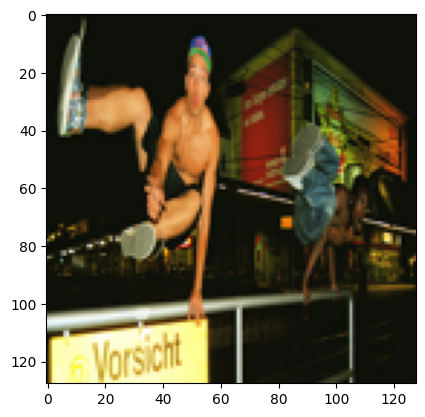

107


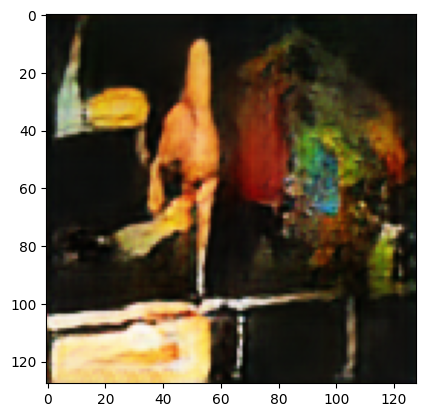

In [24]:
batch = next(iter(vqvae_train))

# Convert PerReplica to a real tensor — pick one replica (usually 0 is fine)
sample_batch = strategy.experimental_local_results(batch)[0]

# If it's (input, label) format
tst = sample_batch[9].numpy()


plt.imshow(tst)
plt.show()
img = np.expand_dims(tst,0)
out = decoder(get_embeddings(get_codebook_indices(img,codebook),codebook))
print(len(np.unique(get_codebook_indices(img,codebook))))
#out = vqvae(img)
plt.imshow(out[0])
plt.show()

In [ ]:
img = Image.open('/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg')
img = img.resize((128,128))
img = np.asarray(img)/255.0
plt.imshow(img)
plt.show()
img = np.expand_dims(img,0)
out = decoder(get_embeddings(get_codebook_indices(img,codebook),codebook))
plt.imshow(out[0])
plt.show()

In [ ]:
print("Total model losses:", vqvae.losses)

In [25]:
BATCH_SIZE = 2048
IMG_SIZE = (128, 128)

df = pd.read_csv('/kaggle/input/flickr30k/captions.txt')
image_paths = ['/kaggle/input/flickr30k/flickr30k_images/' + row.image_name for row in df.itertuples(index=False)]
captions = [row.comment for row in df.itertuples(index=False)]

# Save captions immediately
np.save('Captions.npy', captions)

# ======================
# tf.data Pipeline
# ======================
def preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def create_dataset(image_paths, batch_size):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    img_ds = path_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    img_ds = img_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return img_ds


is_creating = int(input("Do you want to create the dataset ?"))
if is_creating:
    dataset = create_dataset(image_paths, BATCH_SIZE)
    
    # ======================
    # Tokenization Loop
    # ======================
    tokens_list = []
    @tf.function
    def process_batch(images):
        return get_codebook_indices(images, codebook)
        
    with strategy.scope():
        for batch_images in tqdm(dataset, total=len(image_paths) // BATCH_SIZE + 1):
            tokens = process_batch(batch_images)
            tokens_list.append(tokens)
    
        tokens_all = tf.concat(tokens_list, axis=0)  # Shape: (N, H, W)
        tokens_seq = tf.reshape(tokens_all, [tokens_all.shape[0], -1])  # Shape: (N, 64)

# ======================
# Save Tokens
# ======================
    np.save('Tokens_seq.npy', tokens_seq.numpy())
    print("✅ Tokenization complete and saved.")

else:
    captions = np.load('/kaggle/input/vqgan-parts/vqgan_epoch_90/Captions.npy')
    tokens_seq = np.load('/kaggle/input/vqgan-parts/vqgan_epoch_90/Tokens_seq.npy').astype(np.int32)


Do you want to create the dataset ? 1


100%|██████████| 78/78 [1:01:44<00:00, 47.50s/it]


✅ Tokenization complete and saved.


In [ ]:
longest_sentence = max(captions, key=lambda s: len(s.split()))
word_count = len(longest_sentence.split())
print(longest_sentence)

In [ ]:
import string
import re

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string) 
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 18500
sequence_length = 85

vectorizer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)


vectorizer.adapt(captions)
text_vect = tf.cast(vectorizer(captions),tf.int32)

In [ ]:
print(np.shape(tokens_seq))
print(np.shape(text_vect))

In [ ]:
start_tokens = tf.cast(tf.fill([len(text_vect), 1], num_embeddings),tf.int32)
decoder_tokens = tf.concat([start_tokens, tokens_seq], axis=1)

In [ ]:
print(np.shape(decoder_tokens))

In [ ]:
ex = tokens_seq[]
print(len(np.unique(ex)))

In [ ]:
np.min(tokens_seq)

In [ ]:
len(np.unique(tokens_seq[9]))

In [ ]:
random_indices = tf.random.uniform(shape=(1, 16, 16), minval=100, maxval=254, dtype=tf.int32)
flat_indices = tf.reshape(random_indices, [-1])
quantized_vectors = tf.gather(codebook, flat_indices)
quantized_vectors = tf.reshape(quantized_vectors, (1, 16, 16
                                                   , embedding_dim))

# Decode to image
generated_image = decoder(quantized_vectors)
# Display
import matplotlib.pyplot as plt
plt.imshow(generated_image[0].numpy())
plt.axis('off')
plt.title('Random Image from VQ-VAE Codebook')
plt.show()